In [2]:
import pandas as pd
import numpy as np

ONE_DAY_IN_SEC = 86_400
ONE_MONTH_IN_SEC = 2592000

df = pd.read_hdf('data/binance_BTC_USDT.h5')
df.drop(columns=['amount'], inplace=True)
df = df.drop_duplicates()
# df = df.reindex(range(df.index[0], df.index[-1] + 1, 60), fill_value=np.nan)
# df = df.fillna(method='ffill')

df['t_1'] = df['price'].shift(-1)
df['rpc_in'] = df['price'].pct_change()
df['rpc_out'] = df['t_1'].pct_change()

In [3]:
df.head()

,price,t_1,rpc_in,rpc_out
timestamp,,,,
1502942460,4261.480000,4280.560000,NaN,NaN
1502942580,4280.560000,4262.187216,0.004477,-0.004292
1502943480,4262.187216,4264.154634,-0.004292,0.000462
1502943600,4264.154634,4264.985851,0.000462,0.000195
1502943720,4264.985851,4266.290000,0.000195,0.000306


In [4]:
test_set = df.loc[df.index[-1] - 6 * ONE_MONTH_IN_SEC:].copy()
train_set = df.loc[:df.index[-1] - 6 * ONE_MONTH_IN_SEC].copy()
train_set = train_set.drop(train_set.index[0])
test_set = test_set.drop(test_set.index[-1])

In [4]:
import statsmodels.api as sm

acorr = sm.tsa.acf(train_set['price'], nlags=len(train_set) - 1)

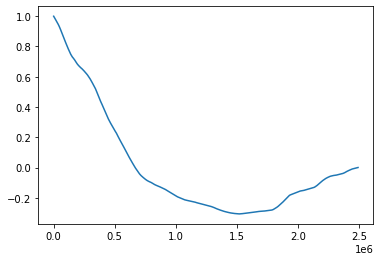

In [5]:
import matplotlib.pyplot as plt

plt.plot(acorr)

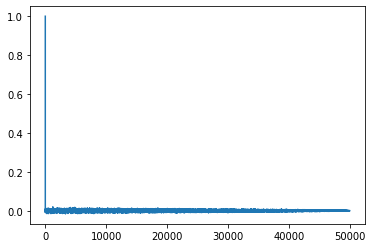

In [6]:
rs = np.random.normal(-3, 12, 50_000)
acorr = sm.tsa.acf(rs, nlags=50_000)
plt.plot(acorr)

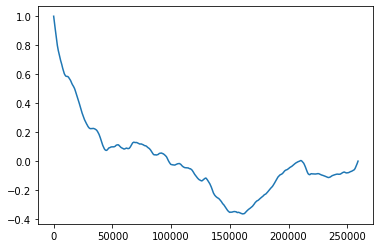

In [7]:
acorr = sm.tsa.acf(test_set['price'], nlags=len(test_set) - 1)
plt.plot(acorr)

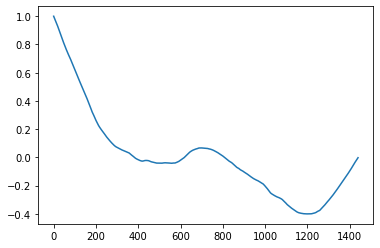

In [8]:
acorr = sm.tsa.acf(test_set['price'].iloc[:int(ONE_DAY_IN_SEC // 60)], nlags=int(ONE_DAY_IN_SEC // 60))
plt.plot(acorr)

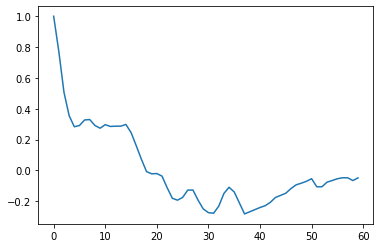

In [9]:
acorr = sm.tsa.acf(test_set['price'].iloc[:60], nlags=60)
plt.plot(acorr)

In [10]:
one_day_price = test_set['price'].iloc[:int(ONE_DAY_IN_SEC // 60)]
one_day_price

timestamp
1654927260    29276.308338
1654927320    29281.207885
1654927380    29291.857317
1654927440    29298.070234
1654927500    29297.742709
                  ...     
1655013360    27381.302545
1655013420    27368.800797
1655013480    27361.345218
1655013540    27337.753537
1655013600    27281.784700
Name: price, Length: 1440, dtype: float64

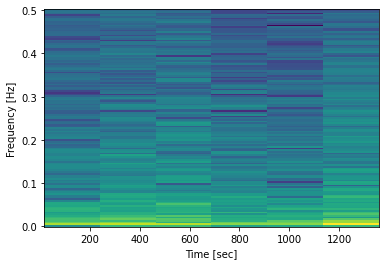

In [11]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(one_day_price)
plt.pcolormesh(t, f, 10*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [12]:
Sxx.shape

(129, 6)

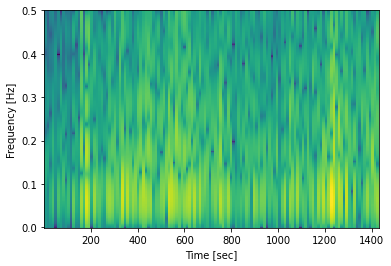

In [36]:
f, t, Sxx = spectrogram(one_day_price, nperseg=12, nfft=511)
plt.pcolormesh(t, f, 10*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [8]:
def data_iterator(df, batch_size=32):
    window_size = int(ONE_DAY_IN_SEC // 60)
    i = 0
    while i + window_size < len(df):
        bs = min(batch_size, len(df) - i - window_size)
        data, targets = [], []
        for _ in range(bs):
            odp = df['price'].iloc[i:i + window_size]
            _, _, spec = spectrogram(odp, nperseg=12, nfft=511)
            data.append(spec[:,:128,np.newaxis])
            targets.append(df['rpc_out'].iloc[i + window_size - 1])
            i += 1
        yield torch.from_numpy(np.array(data, dtype=np.float32)), torch.from_numpy(np.array(targets, dtype=np.float32))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=(4, 3)),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Conv2d(16, 32, kernel_size=3, stride=(3, 2)),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, input_):
        return self.model(input_.permute(0, 3, 1, 2))

In [17]:
batch_size = 128
model = CNNNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
data_provider = data_iterator(train_set.iloc[-3 * int(ONE_MONTH_IN_SEC // 60):], batch_size=batch_size)
with tqdm(total=round(len(train_set) / batch_size)) as pbar:
    for batch in data_provider:
        inputs, targets = batch

        outputs = model(inputs)

        loss = F.mse_loss(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.update(1)
        pbar.postfix = f'\t{loss}'

torch.save(model, 'spectrogram.model')

  0%|                                                                                                                                                                                                          | 0/19445 [00:00<?, ?it/s]/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()
  5%|████████▍                                                                                                                                                           | 1001/19445 [03:27<1:06:35,  4.62it/s, 	0.00047962897224351764]/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([32])) that is differen

In [20]:
import torch
import numpy as np
from scipy.signal import spectrogram

from collections import deque
from strategy import AbstractStrategy
from simulation import simulation
import time

class SpectrogamCNNStrategy(AbstractStrategy):
    def __init__(self, model_path, threshold=0.01):
        self.model = torch.load(model_path)
        self.window_size = int(ONE_DAY_IN_SEC // 60)
        self.history = deque(maxlen=self.window_size)
        self.threshold = threshold

    def get_action(self, current_price):
        self.history.append(current_price)
        if len(self.history) == self.window_size:
            _, _, spec = spectrogram(np.array(self.history), nperseg=12, nfft=511)
            spec = spec[:,:,np.newaxis]
            pred = self.model(torch.from_numpy(np.array([spec], dtype=np.float32)))
            if abs(pred) > self.threshold:
                if pred > 0:
                    return 2
                else:
                    return 1
            else:
                return 0

balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 1000, SpectrogamCNNStrategy(model_path='spectrogram.model'))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [09:08<00:00, 472.27it/s]


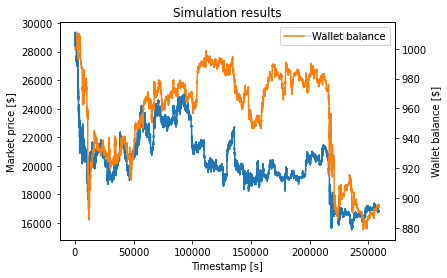

In [21]:
from simulation import plot_sim_results

plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [08:56<00:00, 483.23it/s]


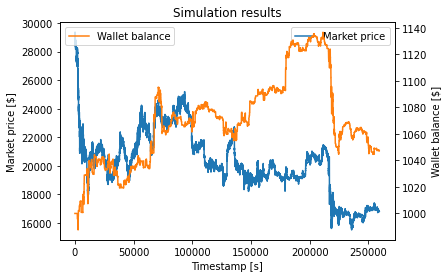

In [23]:
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 
                                       1000, 
                                       SpectrogamCNNStrategy(model_path='spectrogram.model', threshold=0.02))
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [09:20<00:00, 462.75it/s]


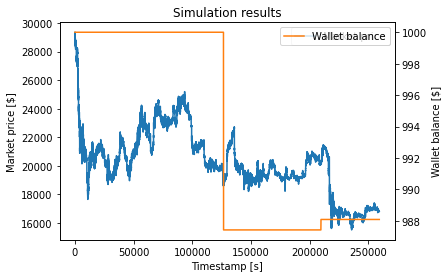

In [24]:
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 
                                       1000, 
                                       SpectrogamCNNStrategy(model_path='spectrogram.model', threshold=0.05))
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [08:58<00:00, 481.07it/s]


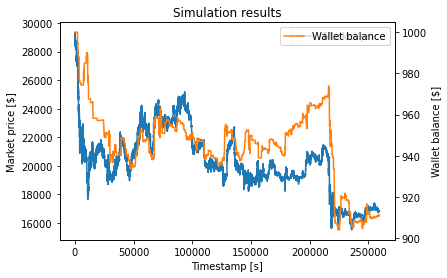

In [25]:
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 
                                       1000, 
                                       SpectrogamCNNStrategy(model_path='spectrogram.model', threshold=0.025))
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [08:57<00:00, 482.26it/s]


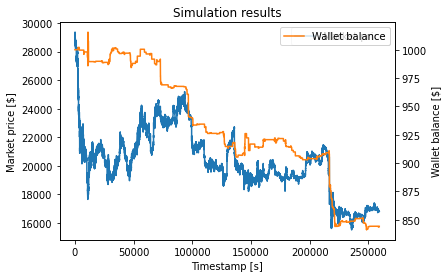

In [26]:
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 
                                       1000, 
                                       SpectrogamCNNStrategy(model_path='spectrogram.model', threshold=0.03))
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [00:00<00:00, 339896.14it/s]


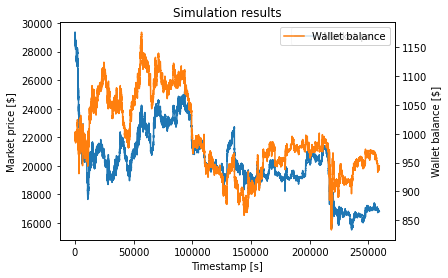

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259200/259200 [00:00<00:00, 803366.39it/s]


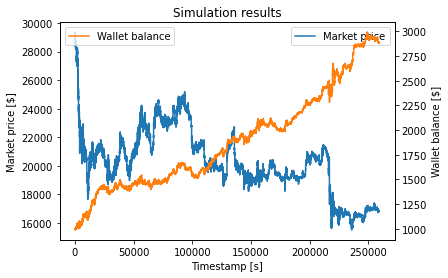

In [32]:
import matplotlib.pyplot as plt
from strategy import RandomStrategy, BaselineStrategy
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 1000, RandomStrategy())
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)
plt.show()
balance, _, _, trajectory = simulation(test_set['price'].to_numpy(), 1000, BaselineStrategy())
plot_sim_results(test_set['price'].to_numpy(), trajectory, twin_axes=True)